На основе подготовленной для нейросети таблицы данных с HeadHunter создайте 6 архитектур нейросетей, поэкспериментируйте с гиперпараметрами.
Используйте только числовые данные, текстовые не подавайте.

Результаты в конце проанализируйте.

Перед началом выполнения, пожалуйста, запустите раздел "Подготовка".

## Подготовка

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [ ]:
# скачиваем базу
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/hh_fixed.csv', None, quiet=True)

# Чтение файла базы данных
df = pd.read_csv('hh_fixed.csv', index_col=0)

# Вывод количества резюме и числа признаков
print(df.shape)

df.head(3)

(62967, 12)


,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано


In [ ]:
# Настройка номеров столбцов

COL_SEX_AGE     = df.columns.get_loc('Пол, возраст')
COL_SALARY      = df.columns.get_loc('ЗП')
COL_POS_SEEK    = df.columns.get_loc('Ищет работу на должность:')
COL_POS_PREV    = df.columns.get_loc('Последеняя/нынешняя должность')
COL_CITY        = df.columns.get_loc('Город')
COL_EMPL        = df.columns.get_loc('Занятость')
COL_SCHED       = df.columns.get_loc('График')
COL_EXP         = df.columns.get_loc('Опыт (двойное нажатие для полной версии)')
COL_EDU         = df.columns.get_loc('Образование и ВУЗ')
COL_UPDATED     = df.columns.get_loc('Обновление резюме')

In [ ]:
# Замена концов строк на пробелы, удаление символа с кодом 0xA0
# обрезка краевых пробелов, приведение к нижнему регистру

def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        x = x.replace('\n', ' ').replace('\xa0', '').strip().lower()
    return x

In [ ]:
# Выделение подстроки вида ДД.ММ.ГГГГ и возвращение значения года

def extract_year(x):
    try:
        return int(re.search(r'\d\d.\d\d.(\d{4})', x)[1])   # Ожидается строка вида 'dd.mm.yyyy ...'

    except (IndexError, TypeError, ValueError):
        return 0

In [ ]:
### Параметрические данные для функций разбора ###

# Курсы валют для зарплат
currency_rate = {'usd'    : 65.,
                 'kzt'    : 0.17,
                 'грн'    : 2.6,
                 'белруб' : 30.5,
                 'eur'    : 70.,
                 'kgs'    : 0.9,
                 'сум'    : 0.007,
                 'azn'    : 37.5
                }

# Списки и словари для разбиения на классы
# Для ускорения работы добавлен счетчик классов, который будет вычислен ниже

# Список порогов возраста
age_class = [0, [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]]

# Список порогов опыта работы в месяцах
experience_class = [0, [7, 13, 25, 37, 61, 97, 121, 157, 193, 241]]

# Классы городов
city_class = [0,
              {'москва'          : 0,
               'санкт-петербург' : 1,
               'новосибирск'     : 2,
               'екатеринбург'    : 2,
               'нижний новгород' : 2,
               'казань'          : 2,
               'челябинск'       : 2,
               'омск'            : 2,
               'самара'          : 2,
               'ростов-на-дону'  : 2,
               'уфа'             : 2,
               'красноярск'      : 2,
               'пермь'           : 2,
               'воронеж'         : 2,
               'волгоград'       : 2,
               'прочие города'   : 3
              }]

# Классы занятости
employment_class = [0,
                    {'стажировка'          : 0,
                     'частичная занятость' : 1,
                     'проектная работа'    : 2,
                     'полная занятость'    : 3
                    }]

# Классы графика работы
schedule_class = [0,
                  {'гибкий график'         : 0,
                   'полный день'           : 1,
                   'сменный график'        : 2,
                   'удаленная работа'      : 3
                  }]

# Классы образования
education_class = [0,
                   {'высшее образование'   : 0,
                    'higher education'     : 0,
                    'среднее специальное'  : 1,
                    'неоконченное высшее'  : 2,
                    'среднее образование'  : 3
                   }]


In [ ]:
# Вычисление счетчиков для данных разбиения

for class_desc in [age_class,
                   experience_class,
                   city_class,
                   employment_class,
                   schedule_class,
                   education_class]:
    if isinstance(class_desc[1], list):
        class_desc[0] = len(class_desc[1]) + 1
    else:
        class_desc[0] = max(class_desc[1].values()) + 1

In [ ]:
 # Получение one hot encoding представления значения класса

 def int_to_ohe(arg, class_list):

    # Определение размерности выходного вектора
    num_classes = class_list[0]

    # Поиск верного интервала для входного значения
    for i in range(num_classes - 1):
        if arg < class_list[1][i]:
            cls = i                       # Интервал найден - назначение класса
            break
    else:                                 # Внимание: for/else
        cls = num_classes - 1             # Интервал не найден - последний класс

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
# Общая функция преобразования строки к multi-вектору
# На входе данные и словарь сопоставления подстрок классам

def str_to_multi(arg, class_dict):
    # Определение размерности выходного вектора
    num_classes = class_dict[0]

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Поиск значения в словаре и, если найдено,
    # выставление 1. на нужной позиции
    for value, cls in class_dict[1].items():
        if value in arg:
            result[cls] = 1.

    return result

In [ ]:
# Разбор значений пола, возраста

base_update_year = 2023

def extract_sex_age_years(arg):
    # Ожидается, что значение содержит "мужчина" или "женщина"
    # Если "мужчина" - результат 1., иначе 0.
    sex = 1. if 'муж' in arg else 0.

    try:
        # Выделение года и вычисление возраста
        years = base_update_year - int(re.search(r'\d{4}', arg)[0])

    except (IndexError, TypeError, ValueError):
        # В случае ошибки год равен 0
        years = 0

    return sex, years

In [ ]:
# Преобразование значения возраста в one hot encoding

def age_years_to_ohe(arg):
    return int_to_ohe(arg, age_class)

In [ ]:
# Преобразование данных об опыте работы в one hot encoding

def experience_months_to_ohe(arg):
    return int_to_ohe(arg, experience_class)

In [ ]:
# Разбор значения зарплаты

def extract_salary(arg):
    try:
        # Выделение числа и преобразование к float
        value = float(re.search(r'\d+', arg)[0])

        # Поиск символа валюты в строке, и, если найдено,
        # приведение к рублю по курсу валюты
        for currency, rate in currency_rate.items():
            if currency in arg:
                value *= rate
                break

    except TypeError:
        # Если не получилось выделить число - вернуть 0
        value = 0.

    return value / 1000.                  # В тысячах рублей

In [ ]:
# Разбор данных о городe и преобразование в one hot encoding

def extract_city_to_ohe(arg):
    # Определение размерности выходного вектора
    num_classes = city_class[0]

    # Разбивка на слова
    split_array = re.split(r'[ ,.:()?!]', arg)

    # Поиск города в строке и присвоение ему класса
    for word in split_array:
        city_cls = city_class[1].get(word, -1)
        if city_cls >= 0:
            break
    else:                                 # Внимание: for/else
        # Город не в city_class - значит его класс "прочие города"
        city_cls = num_classes - 1

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(city_cls, num_classes)

In [ ]:
# Разбор данных о желаемой занятости и преобразование в multi

def extract_employment_to_multi(arg):
    return str_to_multi(arg, employment_class)

In [ ]:
# Разбор данных о желаемом графике работы и преобразование в multi

def extract_schedule_to_multi(arg):
    return str_to_multi(arg, schedule_class)

In [ ]:
# Разбор данных об образовании и преобразование в multi

def extract_education_to_multi(arg):
    result = str_to_multi(arg, education_class)

    # Поправка: неоконченное высшее не может быть одновременно с высшим
    if result[2] > 0.:
        result[0] = 0.

    return result

In [ ]:
# Разбор данных об опыте работы - результат в месяцах

def extract_experience_months(arg):
    try:
        # Выделение количества лет, преобразование в int
        years = int(re.search(r'(\d+)\s+(год.?|лет)', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество лет равно 0
        years = 0

    try:
        # Выделение количества месяцев, преобразование в int
        months = int(re.search(r'(\d+)\s+месяц', arg)[1])

    except (IndexError, TypeError, ValueError):
        # Неудача - количество месяцев равно 0
        months = 0

    # Возврат результата в месяцах
    return years * 12 + months

Функции подготовки выборок

In [ ]:
def extract_row_data(row):

    # Извлечение и преобразование данных
    sex, age = extract_sex_age_years(row[COL_SEX_AGE])      # Пол, возраст
    sex_vec = np.array([sex])                               # Пол в виде вектора
    age_ohe = age_years_to_ohe(age)                         # Возраст в one hot encoding
    city_ohe = extract_city_to_ohe(row[COL_CITY])           # Город
    empl_multi = extract_employment_to_multi(row[COL_EMPL]) # Тип занятости
    sсhed_multi = extract_schedule_to_multi(row[COL_SCHED]) # График работы
    edu_multi = extract_education_to_multi(row[COL_EDU])    # Образование
    exp_months = extract_experience_months(row[COL_EXP])    # Опыт работы в месяцах
    exp_ohe = experience_months_to_ohe(exp_months)          # Опыт работы в one hot encoding
    salary = extract_salary(row[COL_SALARY])                # Зарплата в тысячах рублей
    salary_vec = np.array([salary])                         # Зарплата в виде вектора

    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([sex_vec,
                        age_ohe,
                        city_ohe,
                        empl_multi,
                        sсhed_multi,
                        edu_multi,
                        exp_ohe])

    # Возврат входных данных и выходных (зарплаты)
    return x_data, salary_vec


# Создание общей выборки
def construct_train_data(row_list):
    x_data = []
    y_data = []

    for row in row_list:
        x, y = extract_row_data(row)
        if y[0] > 0:                      # Данные добавляются, только если есть зарплата
            x_data.append(x)
            y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
# Формирование выборки из загруженного набора данных
x_train_01, y_train = construct_train_data(df.values)

In [ ]:
# Форма наборов параметров и зарплат
print(x_train_01.shape)
print(y_train.shape)

# Пример обработанных данных
n = 0
print(x_train_01[n])
print(y_train[n])

(62967, 39)
(62967, 1)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[40.]


Функция отрисовки графика истории обучения

In [ ]:
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

# **Функция оценки модели**

In [ ]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

# **Обучение моделей**

### **Первая модель: lerning_rate = 0.001**

Epoch 1/50
197/197 [==============================] - 2s 4ms/step - loss: 6438.5991 - mae: 51.3655 - val_loss: 4664.3877 - val_mae: 43.6858
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 4705.8555 - mae: 42.7852 - val_loss: 4552.8999 - val_mae: 43.1603
Epoch 3/50
197/197 [==============================] - 1s 5ms/step - loss: 4639.1177 - mae: 42.3030 - val_loss: 4527.0410 - val_mae: 42.1394
Epoch 4/50
197/197 [==============================] - 1s 6ms/step - loss: 4622.1748 - mae: 42.0302 - val_loss: 4503.0781 - val_mae: 42.3749
Epoch 5/50
197/197 [==============================] - 1s 5ms/step - loss: 4603.8345 - mae: 41.8775 - val_loss: 4496.2856 - val_mae: 41.9357
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 4601.7554 - mae: 41.8562 - val_loss: 4493.2070 - val_mae: 41.8896
Epoch 7/50
197/197 [==============================] - 1s 4ms/step - loss: 4600.1001 - mae: 41.8138 - val_loss: 4528.7910 - val_mae: 40.8619
Epoch 8/50
197/197 [

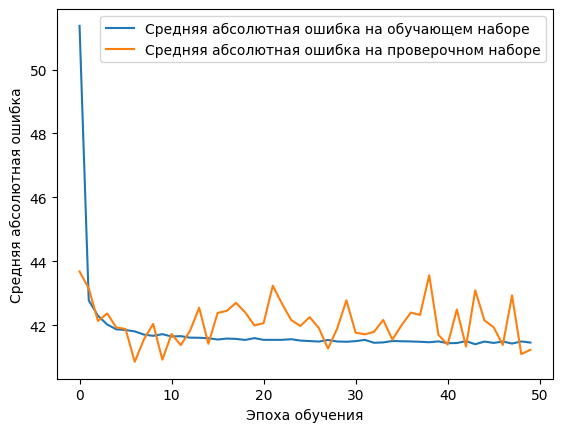

In [ ]:
model_01 = Sequential()
model_01.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_01.add(Dense(800, activation='relu'))
model_01.add(Dropout(0.3))
model_01.add(Dense(1, activation='linear'))

model_01.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

history = model_01.fit(x_train_01,
                    y_train,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 57s 2ms/step
Средняя абсолютная ошибка: 40.812614813020915 

Реальное значение:  40.00  Предсказанное значение:  55.60  Разница:  15.60
Реальное значение:  40.00  Предсказанное значение:  81.53  Разница:  41.53
Реальное значение: 300.00  Предсказанное значение:  90.10  Разница: 209.90
Реальное значение: 180.00  Предсказанное значение:  83.36  Разница:  96.64
Реальное значение:  40.00  Предсказанное значение:  33.26  Разница:   6.74
Реальное значение: 200.00  Предсказанное значение:  94.62  Разница: 105.38
Реальное значение: 120.00  Предсказанное значение: 111.92  Разница:   8.08
Реальное значение:  50.00  Предсказанное значение:  64.98  Разница:  14.98
Реальное значение:  60.00  Предсказанное значение:  47.55  Разница:  12.45
Реальное значение:  70.00  Предсказанное значение:  71.65  Разница:   1.65


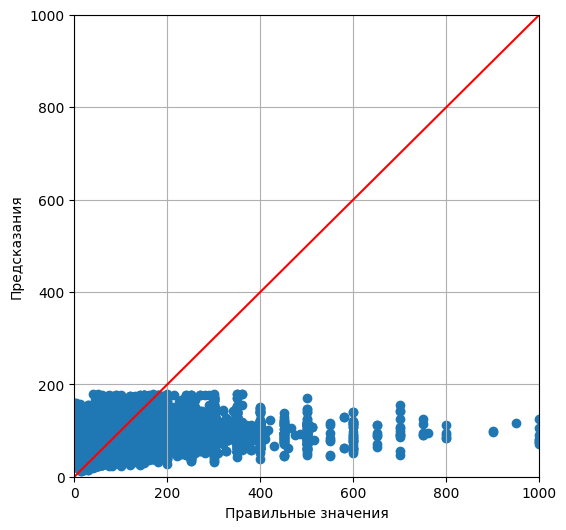

In [ ]:
eval_net(model_01, x_train_01, y_train)

### **Вторая модель: learning_rate = 0.00001**

Epoch 1/50
197/197 [==============================] - 2s 5ms/step - loss: 11239.2988 - mae: 77.3421 - val_loss: 11526.2617 - val_mae: 79.7357
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 11200.6455 - mae: 77.0894 - val_loss: 11482.8613 - val_mae: 79.4613
Epoch 3/50
197/197 [==============================] - 1s 4ms/step - loss: 11153.2158 - mae: 76.7819 - val_loss: 11428.1787 - val_mae: 79.1167
Epoch 4/50
197/197 [==============================] - 2s 10ms/step - loss: 11092.9189 - mae: 76.3918 - val_loss: 11358.5557 - val_mae: 78.6805
Epoch 5/50
197/197 [==============================] - 2s 8ms/step - loss: 11016.6572 - mae: 75.8980 - val_loss: 11270.5684 - val_mae: 78.1310
Epoch 6/50
197/197 [==============================] - 1s 6ms/step - loss: 10921.1143 - mae: 75.2840 - val_loss: 11162.0986 - val_mae: 77.4527
Epoch 7/50
197/197 [==============================] - 1s 4ms/step - loss: 10805.1572 - mae: 74.5317 - val_loss: 11033.2090 - val_mae: 76.6408
Epoch

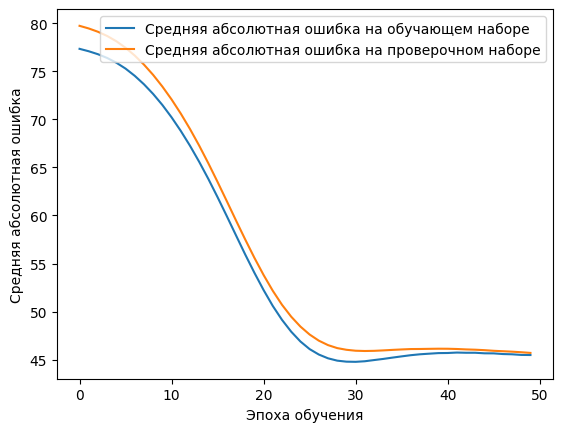

In [ ]:
model_02 = Sequential()
model_02.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_02.add(Dense(800, activation='relu'))
model_02.add(Dropout(0.3))
model_02.add(Dense(1, activation='linear'))

model_02.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics=['mae'])

history = model_02.fit(x_train_01,
                    y_train,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 3s 1ms/step
Средняя абсолютная ошибка: 45.4534461862264 

Реальное значение:  40.00  Предсказанное значение:  68.51  Разница:  28.51
Реальное значение:  40.00  Предсказанное значение:  72.60  Разница:  32.60
Реальное значение: 300.00  Предсказанное значение:  75.04  Разница: 224.96
Реальное значение: 180.00  Предсказанное значение:  81.76  Разница:  98.24
Реальное значение:  40.00  Предсказанное значение:  50.81  Разница:  10.81
Реальное значение: 200.00  Предсказанное значение:  79.85  Разница: 120.15
Реальное значение: 120.00  Предсказанное значение:  76.03  Разница:  43.97
Реальное значение:  50.00  Предсказанное значение:  77.92  Разница:  27.92
Реальное значение:  60.00  Предсказанное значение:  74.17  Разница:  14.17
Реальное значение:  70.00  Предсказанное значение:  78.57  Разница:   8.57


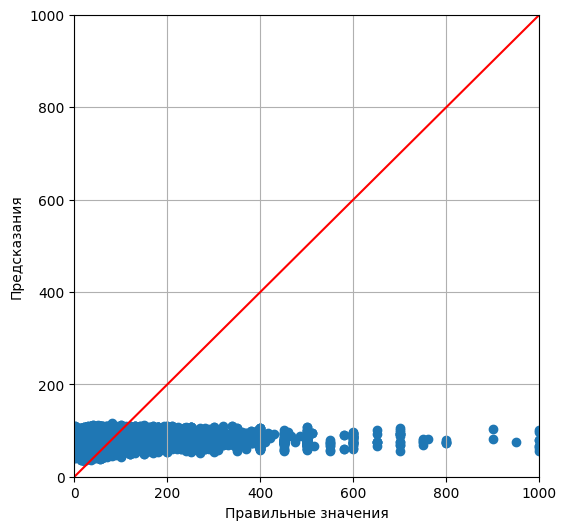

In [ ]:
eval_net(model_02, x_train_01, y_train)

### **Третья модель: learning rate = 0.0000001**

Epoch 1/50
197/197 [==============================] - 2s 5ms/step - loss: 11257.3105 - mae: 77.4561 - val_loss: 11563.5117 - val_mae: 79.9684
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 11256.8232 - mae: 77.4530 - val_loss: 11562.9902 - val_mae: 79.9651
Epoch 3/50
197/197 [==============================] - 1s 4ms/step - loss: 11256.3154 - mae: 77.4493 - val_loss: 11562.4668 - val_mae: 79.9618
Epoch 4/50
197/197 [==============================] - 1s 4ms/step - loss: 11255.7217 - mae: 77.4461 - val_loss: 11561.9463 - val_mae: 79.9585
Epoch 5/50
197/197 [==============================] - 1s 4ms/step - loss: 11255.1787 - mae: 77.4427 - val_loss: 11561.4219 - val_mae: 79.9552
Epoch 6/50
197/197 [==============================] - 1s 4ms/step - loss: 11254.8457 - mae: 77.4399 - val_loss: 11560.8994 - val_mae: 79.9519
Epoch 7/50
197/197 [==============================] - 1s 4ms/step - loss: 11254.2236 - mae: 77.4364 - val_loss: 11560.3760 - val_mae: 79.9485
Epoch 

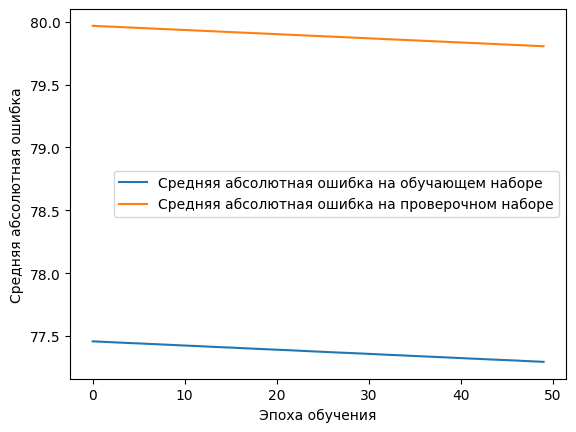

In [ ]:
model_03 = Sequential()
model_03.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_03.add(Dense(800, activation='relu'))
model_03.add(Dropout(0.3))
model_03.add(Dense(1, activation='linear'))

model_03.compile(optimizer=Adam(learning_rate=0.0000001),
                  loss='mse',
                  metrics=['mae'])

history = model_03.fit(x_train_01,
                    y_train,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 3s 2ms/step
Средняя абсолютная ошибка: 77.79417518801299 

Реальное значение:  40.00  Предсказанное значение:   0.20  Разница:  39.80
Реальное значение:  40.00  Предсказанное значение:   0.15  Разница:  39.85
Реальное значение: 300.00  Предсказанное значение:   0.21  Разница: 299.79
Реальное значение: 180.00  Предсказанное значение:   0.16  Разница: 179.84
Реальное значение:  40.00  Предсказанное значение:   0.11  Разница:  39.89
Реальное значение: 200.00  Предсказанное значение:   0.21  Разница: 199.79
Реальное значение: 120.00  Предсказанное значение:   0.16  Разница: 119.84
Реальное значение:  50.00  Предсказанное значение:   0.26  Разница:  49.74
Реальное значение:  60.00  Предсказанное значение:   0.23  Разница:  59.77
Реальное значение:  70.00  Предсказанное значение:   0.23  Разница:  69.77


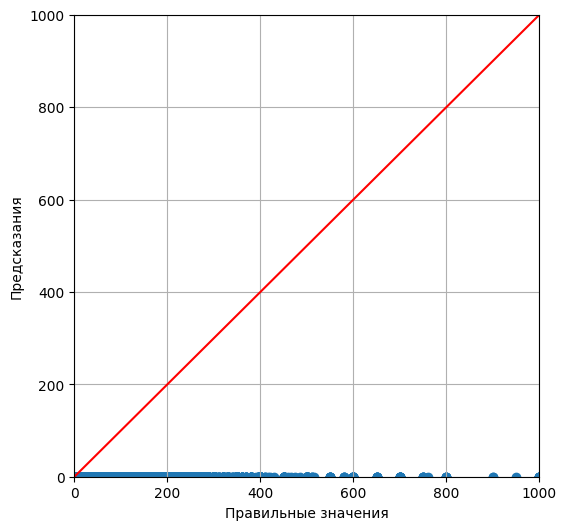

In [ ]:
eval_net(model_03, x_train_01, y_train)

### **Четвёртая модель: learning_rate = 0.00001 + Dense(400) + Dropuot(0.3)**

Epoch 1/50
197/197 [==============================] - 2s 5ms/step - loss: 11191.0098 - mae: 77.0266 - val_loss: 11410.3262 - val_mae: 79.0074
Epoch 2/50
197/197 [==============================] - 1s 4ms/step - loss: 10974.6943 - mae: 75.6283 - val_loss: 11096.1885 - val_mae: 77.0434
Epoch 3/50
197/197 [==============================] - 1s 4ms/step - loss: 10568.3545 - mae: 72.9784 - val_loss: 10563.8193 - val_mae: 73.6278
Epoch 4/50
197/197 [==============================] - 1s 4ms/step - loss: 9910.3672 - mae: 68.4756 - val_loss: 9734.9072 - val_mae: 67.9856
Epoch 5/50
197/197 [==============================] - 1s 5ms/step - loss: 8962.6787 - mae: 61.5258 - val_loss: 8623.6533 - val_mae: 59.8400
Epoch 6/50
197/197 [==============================] - 1s 6ms/step - loss: 7832.8584 - mae: 53.0035 - val_loss: 7424.9619 - val_mae: 51.4226
Epoch 7/50
197/197 [==============================] - 1s 5ms/step - loss: 6772.6392 - mae: 46.4828 - val_loss: 6417.1401 - val_mae: 46.2536
Epoch 8/50
197

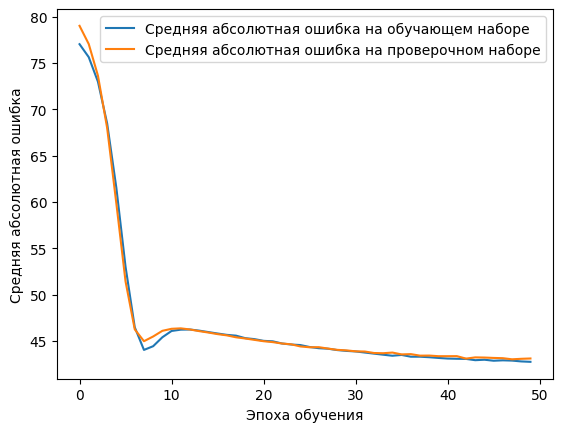

In [ ]:
model_04 = Sequential()
model_04.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_04.add(Dense(800, activation='relu'))
model_04.add(Dropout(0.3))
model_04.add(Dense(400, activation='relu'))
model_04.add(Dropout(0.3))
model_04.add(Dense(1, activation='linear'))

model_04.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics=['mae'])

history = model_04.fit(x_train_01,
                    y_train,
                    batch_size=256,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 42.82814759079763 

Реальное значение:  40.00  Предсказанное значение:  67.36  Разница:  27.36
Реальное значение:  40.00  Предсказанное значение: 106.80  Разница:  66.80
Реальное значение: 300.00  Предсказанное значение:  94.98  Разница: 205.02
Реальное значение: 180.00  Предсказанное значение: 102.65  Разница:  77.35
Реальное значение:  40.00  Предсказанное значение:  38.32  Разница:   1.68
Реальное значение: 200.00  Предсказанное значение:  93.50  Разница: 106.50
Реальное значение: 120.00  Предсказанное значение: 112.97  Разница:   7.03
Реальное значение:  50.00  Предсказанное значение:  75.43  Разница:  25.43
Реальное значение:  60.00  Предсказанное значение:  54.14  Разница:   5.86
Реальное значение:  70.00  Предсказанное значение:  76.63  Разница:   6.63


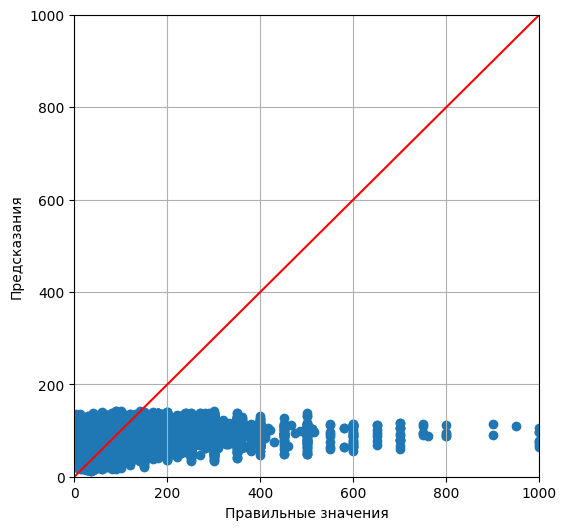

In [ ]:
eval_net(model_04, x_train_01, y_train)

### **Пятая модель: batch_size = 64**

Epoch 1/50
788/788 [==============================] - 6s 5ms/step - loss: 10912.8604 - mae: 75.2351 - val_loss: 10478.9287 - val_mae: 73.1206
Epoch 2/50
788/788 [==============================] - 3s 4ms/step - loss: 8503.3809 - mae: 58.3233 - val_loss: 6728.3276 - val_mae: 47.5992
Epoch 3/50
788/788 [==============================] - 3s 4ms/step - loss: 5757.2988 - mae: 44.5170 - val_loss: 5315.7979 - val_mae: 45.8439
Epoch 4/50
788/788 [==============================] - 4s 5ms/step - loss: 5300.1777 - mae: 46.0119 - val_loss: 5136.2393 - val_mae: 46.1039
Epoch 5/50
788/788 [==============================] - 3s 4ms/step - loss: 5180.8813 - mae: 45.8908 - val_loss: 5038.7358 - val_mae: 45.6720
Epoch 6/50
788/788 [==============================] - 3s 4ms/step - loss: 5099.7046 - mae: 45.4969 - val_loss: 4965.3403 - val_mae: 45.3145
Epoch 7/50
788/788 [==============================] - 3s 4ms/step - loss: 5039.5220 - mae: 45.1244 - val_loss: 4907.6880 - val_mae: 45.1179
Epoch 8/50
788/788

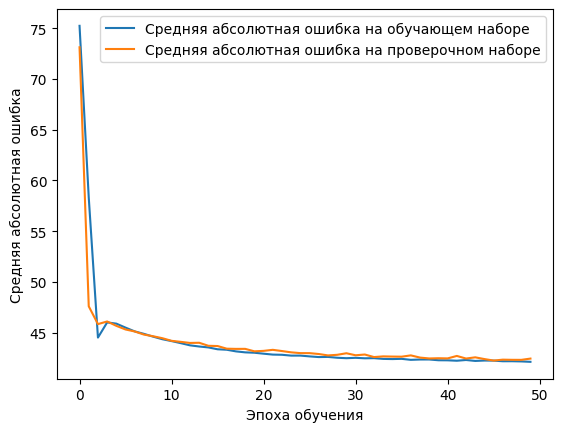

In [ ]:
model_05 = Sequential()
model_05.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_05.add(Dense(800, activation='relu'))
model_05.add(Dropout(0.3))
model_05.add(Dense(400, activation='relu'))
model_05.add(Dropout(0.3))
model_05.add(Dense(1, activation='linear'))

model_05.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics=['mae'])

history = model_05.fit(x_train_01,
                    y_train,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 42.151298853259824 

Реальное значение:  40.00  Предсказанное значение:  62.54  Разница:  22.54
Реальное значение:  40.00  Предсказанное значение:  96.50  Разница:  56.50
Реальное значение: 300.00  Предсказанное значение:  95.54  Разница: 204.46
Реальное значение: 180.00  Предсказанное значение:  95.13  Разница:  84.87
Реальное значение:  40.00  Предсказанное значение:  32.77  Разница:   7.23
Реальное значение: 200.00  Предсказанное значение:  98.43  Разница: 101.57
Реальное значение: 120.00  Предсказанное значение: 111.74  Разница:   8.26
Реальное значение:  50.00  Предсказанное значение:  77.59  Разница:  27.59
Реальное значение:  60.00  Предсказанное значение:  57.61  Разница:   2.39
Реальное значение:  70.00  Предсказанное значение:  74.14  Разница:   4.14


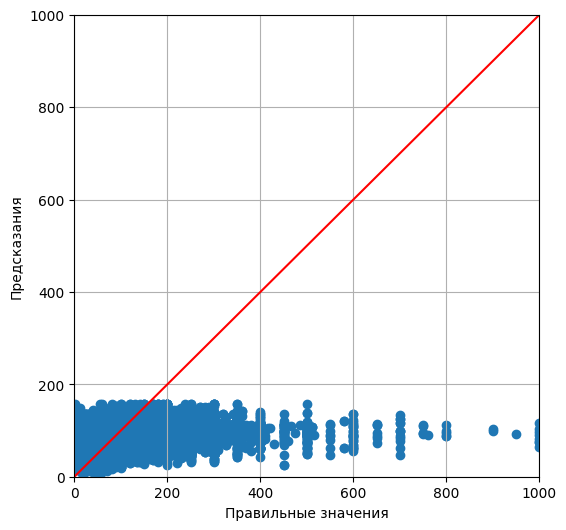

In [ ]:
eval_net(model_05, x_train_01, y_train)

### **Шестая модель: epochs = 25 + Dense(200) + Dropout(0.3)**

Epoch 1/25
788/788 [==============================] - 6s 5ms/step - loss: 10098.9014 - mae: 69.5669 - val_loss: 7225.9771 - val_mae: 50.7505
Epoch 2/25
788/788 [==============================] - 4s 5ms/step - loss: 5725.0469 - mae: 46.0948 - val_loss: 5252.8750 - val_mae: 46.4144
Epoch 3/25
788/788 [==============================] - 3s 4ms/step - loss: 5306.7891 - mae: 46.3794 - val_loss: 5095.8540 - val_mae: 45.5425
Epoch 4/25
788/788 [==============================] - 4s 6ms/step - loss: 5195.3242 - mae: 45.8215 - val_loss: 4995.2163 - val_mae: 45.3377
Epoch 5/25
788/788 [==============================] - 4s 5ms/step - loss: 5118.9873 - mae: 45.4536 - val_loss: 4923.7837 - val_mae: 45.1840
Epoch 6/25
788/788 [==============================] - 4s 5ms/step - loss: 5059.0000 - mae: 45.1458 - val_loss: 4877.4160 - val_mae: 44.5733
Epoch 7/25
788/788 [==============================] - 4s 5ms/step - loss: 5018.4912 - mae: 44.7309 - val_loss: 4828.9785 - val_mae: 44.6181
Epoch 8/25
788/788 

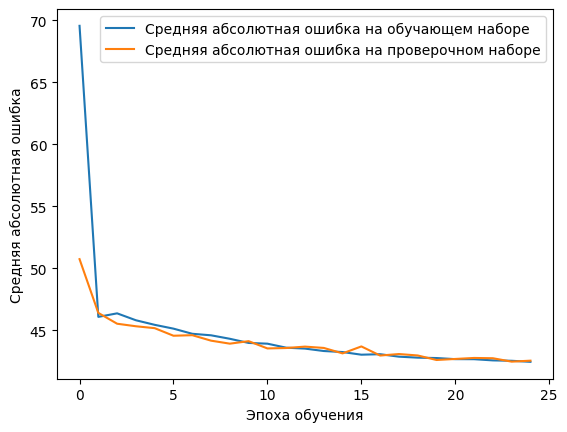

In [ ]:
model_06 = Sequential()
model_06.add(Dense(30, activation='relu', input_dim=x_train_01.shape[1]))
model_06.add(Dense(800, activation='relu'))
model_06.add(Dropout(0.3))
model_06.add(Dense(400, activation='relu'))
model_06.add(Dropout(0.3))
model_06.add(Dense(200, activation='relu'))
model_06.add(Dropout(0.3))
model_06.add(Dense(1, activation='linear'))

model_06.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='mse',
                  metrics=['mae'])

history = model_06.fit(x_train_01,
                    y_train,
                    batch_size=64,
                    epochs=25,
                    validation_split=0.2,
                    verbose=1)

plot_history(history)

1968/1968 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 42.22939276120448 

Реальное значение:  40.00  Предсказанное значение:  60.28  Разница:  20.28
Реальное значение:  40.00  Предсказанное значение: 101.57  Разница:  61.57
Реальное значение: 300.00  Предсказанное значение:  94.76  Разница: 205.24
Реальное значение: 180.00  Предсказанное значение:  99.86  Разница:  80.14
Реальное значение:  40.00  Предсказанное значение:  31.80  Разница:   8.20
Реальное значение: 200.00  Предсказанное значение:  96.16  Разница: 103.84
Реальное значение: 120.00  Предсказанное значение: 106.76  Разница:  13.24
Реальное значение:  50.00  Предсказанное значение:  89.48  Разница:  39.48
Реальное значение:  60.00  Предсказанное значение:  75.08  Разница:  15.08
Реальное значение:  70.00  Предсказанное значение:  75.28  Разница:   5.28


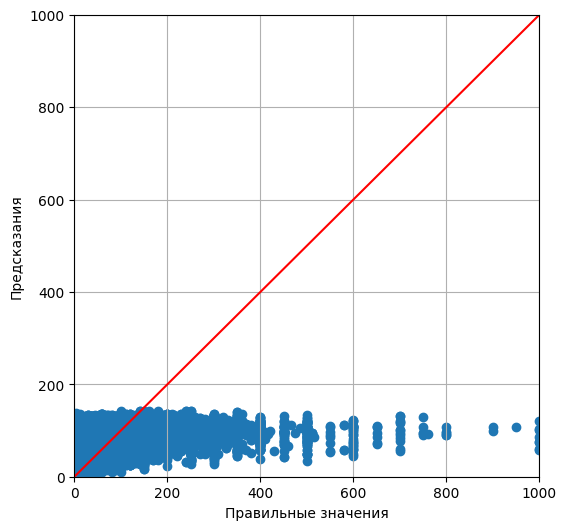

In [ ]:
eval_net(model_06, x_train_01, y_train)

По результатам 6 моделей можно сделать вывод, что независимо от гиперпараметров, улучшающих работу сети, модели не дают результаты лучше, чем с ~42 средней ошибкой. Для лучшего результата нужна нормализация данных.